In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random
import  scipy.io
import torch
from torch.nn.functional import conv2d

In [2]:
train_x=np.load("task3_data/train_x.npy")
train_y=np.load("task3_data/train_y.npy")
test_x=np.load("task3_data/test_x.npy")
test_y=np.load("task3_data/test_y.npy")
#train_x=train_x.reshape(train_x.shape[0],train_x.shape[1]*train_x.shape[2])
#test_x=test_x.reshape(test_x.shape[0],test_x.shape[1]*test_x.shape[2])
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [3]:
def load_filters(path):
    data = scipy.io.loadmat(path+'\\filters.mat')
    filters = data['filters']
    filters = np.array(filters)
    return filters
def plot_filters(filters):
    fig, axes = plt.subplots(6, 6, figsize=(15,5))
    itr = 0
    for i in range(6):
        for j in range(6):
            axes[i, j].imshow(filters[:, :,itr])
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            itr += 1
def size_for_convolution(image_dim,kernal_dim,padding,stride):
    height = int((image_dim[0]-kernal_dim[0]+2*padding)/stride)+1
    width = int((image_dim[1]-kernal_dim[1]+2*padding)/stride)+1
    return height,width
def conv_single_step(img_patch, filtr):
    conv=np.multiply(img_patch,filtr)
    return np.sum(conv)

In [4]:
def conv_forward(sample, filters, stride=1, pad=0):
    height, width=size_for_convolution(sample.shape,filters.shape,pad,stride)
    result=np.zeros((height,width,filters.shape[2]))
    for f in range(0,filters.shape[2]):
        filtr=filters[:,:,f]
        i=j=0
        filter_width=filter_height=filters.shape[0]
        while i<height:
            j=0
            while j<width:
                patch=sample[i:i+filter_height,j:j+filter_width]
                output=conv_single_step(patch,filtr)
                result[i,j,f]=output
                j=j+stride
            i=i+stride
            
    return result

In [5]:
def pool_forward(sample,feature_map, mode = "max", filter_size=2, stride=2):
    indicies=[]
    height, width=size_for_convolution(sample.shape,filters.shape,0,stride)  ##call this function to compute the dimensions
    result=np.zeros((height,width,filters.shape[2]))                  ## of new image
    for f in range(0,feature_map.shape[2]):   ###loop to control convolved image
        i=0
        a=0
        filter_width=filter_height=filter_size   ###initialize width,height, and size
        while (i+filter_height)<=feature_map.shape[0]:
            j=0
            b=0
            while (j+filter_width)<=feature_map.shape[1]:
                #result[a,b,f]=feature_map[i:i+filter_height,j:j+filter_width,f].max()##Computing the max value
                indicies.append(feature_map[i:i+filter_height,j:j+filter_width,f])
                j=j+stride
                b+=1
            i=i+stride
            a+=1
    return np.array(indicies)

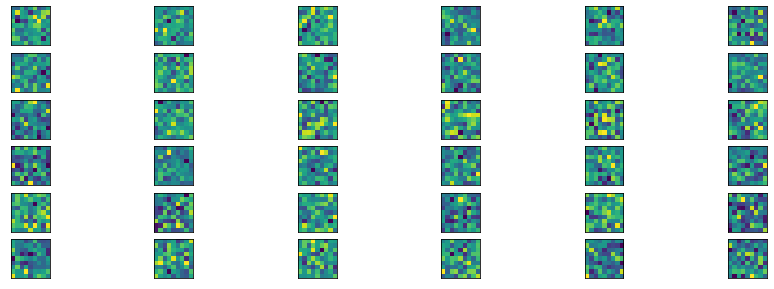

In [6]:
#filters= load_filters("D:\\MS\\Spring 2020\\Deep Learning\\Assignment 03\\")
#print(filters.shape)
filters=np.random.randn(9,9,36)
#print(new_fil.shape)
#filters=new_fil
plot_filters(filters)

In [7]:
def init_network(no_of_layers, input_dim,neurons_per_layer):
    layers_params={}

    for i in range(0,len(neurons_per_layer)):
        if i==0:
            layers_params["W1"]=np.random.randn(input_dim,neurons_per_layer[0]) 
            print("W1 Shape",layers_params["W1"].shape)
            layers_params["B1"]=np.random.randn(neurons_per_layer[0],1)
            #layers_params["B1"]=np.expand_dims(layers_params["B1"],axis=-1)
            print("B1 Shape",layers_params["B1"].shape)
            layers_params["Z1"]=np.zeros((neurons_per_layer[0],1))
            #layers_params["Z1"]=np.expand_dims(layers_params["Z1"],axis=-1)
            print("Z1 Shape",layers_params["Z1"].shape)
            layers_params["A1"]=np.zeros((neurons_per_layer[0],1))
            #layers_params["A1"]=np.expand_dims(layers_params["A1"],axis=-1)
            print("A1 Shape",layers_params["A1"].shape)
        else:
            layers_params[f"W{(i+1)}"]=np.random.randn(neurons_per_layer[i-1],neurons_per_layer[i])
            print("W"+str(i+1)+" Shape",layers_params[f"W{(i+1)}"].shape)
            layers_params[f"B{(i+1)}"]=np.random.randn(neurons_per_layer[i],1)
            #layers_params[f"B{(i+1)}"]=np.expand_dims(layers_params[f"B{(i+1)}"],axis=-1)
            print("B"+str(i+1)+" Shape",layers_params[f"B{(i+1)}"].shape)
            layers_params[f"Z{(i+1)}"]=np.zeros((neurons_per_layer[i],1))
            #layers_params[f"Z{(i+1)}"]=np.expand_dims(layers_params[f"Z{(i+1)}"],axis=-1)
            print("Z"+str(i+1)+" Shape",layers_params[f"Z{(i+1)}"].shape)
            layers_params[f"A{(i+1)}"]=np.zeros((neurons_per_layer[i],1))
            #layers_params[f"A{(i+1)}"]=np.expand_dims(layers_params[f"A{(i+1)}"],axis=-1)
            print("A"+str(i+1)+" Shape",layers_params[f"A{(i+1)}"].shape)
    return layers_params

In [8]:
def sigmoid(s):
    return 1/(1+np.exp(-s))
def sigmoid_derivative(s):
    return s*(1-s)
def MeanImageSubtraction(all_data):
    m_data=np.mean(all_data,axis=0)
    m_data=np.expand_dims(m_data,axis=-1)
    return m_data
def softmax(s):
    s=np.exp(s)
    sum_s=np.sum(s)
    #sum_s=np.expand_dims(sum_s,axis=1)
    return s/sum_s 
def one_hot_encoding(data):
    Y=[]
    for i in range(0,len(data)):
        temp=np.zeros(10,dtype=int)
        if data[i]==0:
            temp[0]=1
            Y.append(temp)
        if data[i]==1:
            temp[1]=1
            Y.append(temp)
        if data[i]==2:
            temp[2]=1
            Y.append(temp)
        if data[i]==3:
            temp[3]=1
            Y.append(temp)
        if data[i]==4:
            temp[4]=1
            Y.append(temp)
        if data[i]==5:
            temp[5]=1
            Y.append(temp)
        if data[i]==6:
            temp[6]=1
            Y.append(temp)
        if data[i]==7:
            temp[7]=1
            Y.append(temp)
        if data[i]==8:
            temp[8]=1
            Y.append(temp)
        if data[i]==9:
            temp[9]=1
            Y.append(temp)
        #print(temp)
    return np.array(Y)

def crossentropyloss(y_pred,Y):
    cel=0;
    for i in range(0,len(Y)):
        cel+= Y[i]*np.log(y_pred[i])
    return -cel

In [9]:
def feedforward(net,trainX, no_of_layers):
    net["Z1"]=np.dot(net["W1"].T,trainX) + net["B1"]
    net["A1"]=sigmoid(net["Z1"])
    for i in  range(1,no_of_layers+1):
        net[f"Z{(i+1)}"]=np.dot(net[f"W{(i+1)}"].T,net[f"A{(i)}"]) +net[f"B{(i+1)}"]
        if i<no_of_layers:
            net[f"A{(i+1)}"]=sigmoid(net[f"Z{(i+1)}"])
            continue
        net[f"A{(i+1)}"]=softmax(net[f"Z{(i+1)}"])
    return net[f"A{(i+1)}"]

In [10]:
def Backwardpropagate(sample, y_pred,Y,net,lr):
    dL_params={}
    ###for last layer 
    Y=np.expand_dims(Y,axis=-1)
    error=y_pred-Y ##error
    dL_params[f"dW{(no_of_layers+1)}"]=np.dot(net["A"+str(no_of_layers)],error.T)
    dL_params[f"dB{(no_of_layers+1)}"]=np.sum(dL_params[f"dW{(no_of_layers+1)}"].T,axis=1,keepdims=True)
    ###for intermdeiate layer
    dZ = np.multiply(sigmoid_derivative(net["A2"]),np.dot(net["W3"],error))
    dL_params[f"dW{(no_of_layers)}"]=np.dot(net["A1"],dZ.T)
    dL_params[f"dB{(no_of_layers)}"]=np.sum(dL_params[f"dW{(no_of_layers)}"].T,axis=1,keepdims=True)
    ###for first layer
    dZ1=np.multiply(sigmoid_derivative(net["A1"]),np.dot(net["W2"],dZ))
    delta=np.dot(net["W1"],dZ1)
    dL_params[f"dW{(no_of_layers-1)}"]=np.dot(sample,dZ1.T)
    dL_params[f"dB{(no_of_layers-1)}"]=np.sum(dL_params[f"dW{(no_of_layers-1)}"].T,axis=1,keepdims=True)
    return dL_params[f"dW{(no_of_layers+1)}"],dL_params[f"dB{(no_of_layers+1)}"],dL_params[f"dW{(no_of_layers)}"],dL_params[f"dB{(no_of_layers)}"],dL_params[f"dW{(no_of_layers-1)}"],dL_params[f"dB{(no_of_layers-1)}"],delta

In [11]:
def relu(s):
    return np.maximum(s,0);

def relu_derivative(s):
    s[s<=0] = 0
    s[s>0] = 1
    return s

In [12]:
def Maxpool(conv_result):
    maxID=np.zeros((conv_result.shape[0],conv_result.shape[1],conv_result.shape[2]))
    stride = 2
    fs = 2
    a=conv_result
    conv_mats = np.array([ [ [ [np.max(a[j:j+fs,k:k+fs,i]),([j,k]+np.array(np.unravel_index(np.argmax(a[j:j+fs,k:k+fs,i] , axis=None),a[j:j+fs,k:k+fs,i].shape)))] for k in range(0,a.shape[1]-fs+1,stride)] for j in range(0,a.shape[0]-fs+1,stride)] for i in range(0,a.shape[-1])])
    #conv_mats=conv_mats.reshape(conv_mats.shape[0]*conv_mats.shape[1]*conv_mats.shape[2],2)
    return conv_mats
                        

In [13]:
def Update_params(W3,B3,W2,B2,W1,B1):
    net['W3'] -= lr*W3 ###weights updation
    net['B3'] -= lr*B3###bias updation
    net['W2'] -= lr*W2 ###weights updation
    net['B2'] -= lr*B2###bias updation
    net['W1'] -= lr*W1 ###weights updation
    net['B1'] -= lr*B1###bias updation
    return

In [14]:
def accuracy(X,Y,bias):
    count=0;
    for i in range(0,len(X)):
        conv_res=conv_forward(X[i],filters)
        conv_res=conv_res+bias
        conv_res=relu(conv_res)
        pooled_result=Maxpool(conv_res)
        size=pooled_result.shape[0]*pooled_result.shape[1]*pooled_result.shape[2]
        flatt=pooled_result
        flatt=flatt.reshape(size,2)
        flatten=[]
        for val in flatt:
            flatten.append(val[0])
        flatten=np.array(flatten)
        flatten=np.expand_dims(flatten,axis=-1)
        y_pred_tst=feedforward(net,flatten,no_of_layers)
        if np.argmax(y_pred_tst)==np.argmax(Y[i]):
            count+=1
    print("Accuracy = ",count/len(Y))
    return count/len(Y)



In [15]:
def convolution(a,b):
    a=np.expand_dims(a,axis=-1)
    a=np.expand_dims(a,axis=-1)
    a=a.T
    b=b.T
    b=np.expand_dims(b,axis=1)
    inputs = torch.from_numpy(a).float()
    filters = torch.from_numpy(b).float()
    out = torch.nn.functional.conv2d(inputs, filters,stride=1,padding=0, bias=None)
    out=np.squeeze(np.array(out),axis=0)
    return out.T

In [16]:
conv_res=convolution(train_x[0],filters)
pooled_result=Maxpool(conv_res)
bias=np.random.randn(conv_res.shape[0],conv_res.shape[1],conv_res.shape[2])
no_of_layers=2;
input_dim=pooled_result.shape[0]*pooled_result.shape[1]*pooled_result.shape[2]
neurons_per_layer=[128,64,10]
net=init_network(no_of_layers,input_dim,neurons_per_layer)

W1 Shape (3600, 128)
B1 Shape (128, 1)
Z1 Shape (128, 1)
A1 Shape (128, 1)
W2 Shape (128, 64)
B2 Shape (64, 1)
Z2 Shape (64, 1)
A2 Shape (64, 1)
W3 Shape (64, 10)
B3 Shape (10, 1)
Z3 Shape (10, 1)
A3 Shape (10, 1)


In [17]:
def Mask(index,conv_res):
    maxID=np.zeros((conv_res.shape[0],conv_res.shape[1],conv_res.shape[2]))
    #print(index.shape)
    i=j=k=0 
    while(k<index.shape[0]):
        m=index[k][i][j][1][0]
        n=index[k][i][j][1][1]
        maxID[m][n][k] = 1
        j += 1
        if(j%index.shape[1]==0):
            j=0
            i+= 1
            if (i%index.shape[2]==0):
                i=0
                k+= 1
    return maxID

In [18]:
def MeanImageSubtraction(all_data):
    m_data=np.mean(all_data,axis=0)
    m_data=np.expand_dims(m_data,axis=-1)
    return m_data

In [19]:
X2=test_x
X1=train_x
X=np.concatenate((X1,X2),axis=0)
mIS=MeanImageSubtraction(X1)
train_x=np.subtract(X1,mIS.T)
test_x=np.subtract(X2,mIS.T)

In [20]:
indices=[]
for i in range(0,len(train_x),6000):
    indices.append(random.sample(range(i, i+6000-1),200))
a=[]
b=[]
for index in indices:
    a.append(X1[index])
    b.append(train_y[index])
X=np.array(a)
Y=np.array(b)
X=np.concatenate((X[0],X[1],X[2],X[3],X[4],X[5],X[6],X[7],X[8],X[9]),axis=0)
Y=np.concatenate((Y[0],Y[1],Y[2],Y[3],Y[4],Y[5],Y[6],Y[7],Y[8],Y[9]),axis=0)
print(X.shape)
print(Y.shape)

(2000, 28, 28)
(2000,)


In [21]:
accu_vect=[]
loss_vect=[]
lr=0.0001
epochs=20

In [22]:
Y=one_hot_encoding(Y)
epochs=50
for j in range(0,epochs):
    print("Epoch #",j+1)
    loss=0
    p=np.random.permutation(len(X))
    trX=X[p]
    trY=Y[p]
    for i in range(0,len(trX)):
        #print("Image #",i+1)
        conv_res=conv_forward(trX[i],filters)  #Step 1: Perform convolution
        conv_res=conv_res+bias     ###Step 2: Add bias
        conv_res=relu(conv_res)###Step 3: Perform Relu activation
        #print(conv_res.shape)
        pooled_result=Maxpool(conv_res) ### step 4: perform Max pooling
        #print("Max pool Shape",pooled_result.shape)
        maxID=Mask(pooled_result,conv_res)
        #print(maxID.shape)
        size=pooled_result.shape[0]*pooled_result.shape[1]*pooled_result.shape[2]
        flatt=pooled_result
        flatt=flatt.reshape(size,2)
        flatten=[]
        for flat in flatt:
            flatten.append(flat[0])
        flatten=np.expand_dims(np.array(flatten),axis=-1)
        y_pred=feedforward(net,flatten,no_of_layers)  ### Step 7: Send to FC layyers
        loss+=crossentropyloss(y_pred,trY[i]) #step 8: Compute loss
        W3,B3,W2,B2,W1,B1,dL=Backwardpropagate(flatten,y_pred,trY[i],net,lr)#Step 9: Backprop of FC layer(s)
        #print(dL.shape)
        dL=dL.reshape(pooled_result.shape[1],pooled_result.shape[2],pooled_result.shape[0]) #Step 10: Unflatten the flattend
        dL=np.concatenate((dL,dL),axis=1)
        dL=np.concatenate((dL,dL),axis=0)
        dL_max_pool=np.multiply(dL,maxID)  #Step 12: Backpropagation of Max-pooling layer
        dL_b=dL_max_pool                  ##Used to update bias
        dL_max_pool=np.flipud(dL_max_pool)
        dL_max_pool=np.flipud(dL_max_pool)
        #print(dL.shape)
        dL=np.multiply(dL,relu_derivative(dL_max_pool)) #Step 13: Apply derivative of Activation function
        filrs=conv_forward(trX[i],dL) #convolv with input to update filters
        Update_params(W3,B3,W2,B2,W1,B1)
        filters   -=lr*filrs
        bias      -=lr*dL_b
        if(i%999==0 and i>0):
            q=random.sample(range(0,i),300)
            valX=trX[q]
            valY=trY[q]
            print("After",i,"Images")
            accu_vect.append(accuracy(valX,valY,bias))
            print("Loss = ",loss/i)
        loss_vect.append(loss)

Epoch # 1


c:\users\m ahsan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


After 999 Images
Accuracy =  0.13
Loss =  [6.36202742]
After 1998 Images
Accuracy =  0.13
Loss =  [5.9615002]
Epoch # 2
After 999 Images
Accuracy =  0.15666666666666668
Loss =  [5.09031656]
After 1998 Images
Accuracy =  0.20333333333333334
Loss =  [4.70150252]
Epoch # 3
After 999 Images
Accuracy =  0.18666666666666668
Loss =  [3.84323449]
After 1998 Images
Accuracy =  0.18333333333333332
Loss =  [3.84716872]
Epoch # 4
After 999 Images
Accuracy =  0.19
Loss =  [3.8374576]
After 1998 Images
Accuracy =  0.15
Loss =  [3.7208573]
Epoch # 5
After 999 Images
Accuracy =  0.17666666666666667
Loss =  [3.57943664]
After 1998 Images
Accuracy =  0.16
Loss =  [3.55951583]
Epoch # 6
After 999 Images
Accuracy =  0.13
Loss =  [3.44021869]
After 1998 Images
Accuracy =  0.18
Loss =  [3.44022714]
Epoch # 7
After 999 Images
Accuracy =  0.16333333333333333
Loss =  [3.3439859]
After 1998 Images
Accuracy =  0.16666666666666666
Loss =  [3.33146066]
Epoch # 8
After 999 Images
Accuracy =  0.15333333333333332
Los

KeyboardInterrupt: 

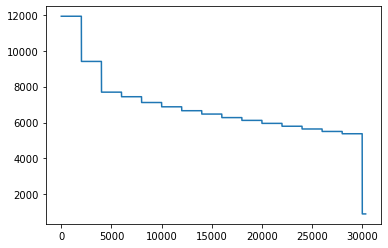

In [23]:
plt.plot(loss_vect)

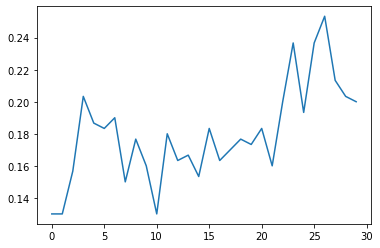

In [24]:
plt.plot(accu_vect)

In [ ]:
plot_filters(filters)